In [1]:
from scipy.signal import butter, lfilter
from scipy.spatial.distance import euclidean
from scipy.signal import wiener
import pywt

In [2]:
import pandas as pd
import preprocessing
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=1, mode='hard'):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode=mode) for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [5]:
def SNR(orig, est):
    return 10* np.log10((np.mean(orig**2)/np.mean((orig-est)**2)))

def distortion(orig, est):
    num = np.mean((orig - (np.mean(orig**2)/np.mean(est**2))*est)**2)
    denom = np.mean(orig**2)
    return 10*np.log10(num/denom)

In [6]:
noisy_dir = 'TestNoisy2//'
clean_dir = 'TestSetPrepped//'

In [7]:
bandpass_dir = 'BandpassTestSet//'
weiner_dir = 'WeinerTestSet//'
wavelet_dir = 'WaveletTestSet//'

In [30]:
results = pd.DataFrame(columns=['file', 'noisy', 'bandpass', 'weiner', 'wavelet'])
for file in os.listdir(noisy_dir):
    if file.endswith('.wav'):
        clean_signal, sr = librosa.load(clean_dir+file)
        noisy_signal, _ = librosa.load(noisy_dir+file, sr=sr)
        bandpass_signal, _ = librosa.load(bandpass_dir+file, sr=sr)
        weiner_signal, _ = librosa.load(weiner_dir+file, sr=sr)
        wavelet_signal, _ = librosa.load(wavelet_dir+file, sr=sr)
        
        max_len = max(len(noisy_signal), len(clean_signal), len(bandpass_signal), len(weiner_signal), len(wavelet_signal))
        clean_signal = np.pad(clean_signal, (0, max_len-len(clean_signal)), 'constant')
        noisy_signal = np.pad(noisy_signal, (0, max_len-len(noisy_signal)), 'constant')
        bandpass_signal = np.pad(bandpass_signal, (0, max_len-len(bandpass_signal)), 'constant')
        weiner_signal = np.pad(weiner_signal, (0, max_len-len(weiner_signal)), 'constant')
        wavelet_signal = np.pad(wavelet_signal, (0, max_len-len(wavelet_signal)), 'constant')
        
        new_row = [file, SNR(clean_signal, noisy_signal), SNR(clean_signal, bandpass_signal), SNR(clean_signal, weiner_signal), SNR(clean_signal, wavelet_signal)]
        results.loc[len(results)]=new_row

In [31]:
len(clean_signal)

14399

In [32]:
results.head()

,file,noisy,bandpass,weiner,wavelet
0,100-a_n.wav,18.428140,20.904565,23.603761,21.858349
1,100-i_n.wav,8.899171,12.385437,12.989707,10.594164
2,100-u_n.wav,16.657873,20.003803,21.522322,23.070927
3,1005-a_n.wav,19.110490,16.499567,23.750477,19.219506
4,1005-i_n.wav,18.874332,17.017754,21.612012,16.907171


In [33]:
results.shape

(69, 5)

In [34]:
snr_list = []
for snr in results['noisy']:
    if abs(snr-20) < abs(snr-10):
        snr_list.append(20)
    elif abs(snr-10) < abs(snr-5):
        snr_list.append(10)
    else:
        snr_list.append(5)

In [35]:
results['category'] = snr_list
results['category'].value_counts()

5     31
20    21
10    17
Name: category, dtype: int64

In [36]:
snr5_index = results['category']==5
snr10_index = results['category']==10
snr20_index = results['category']==20

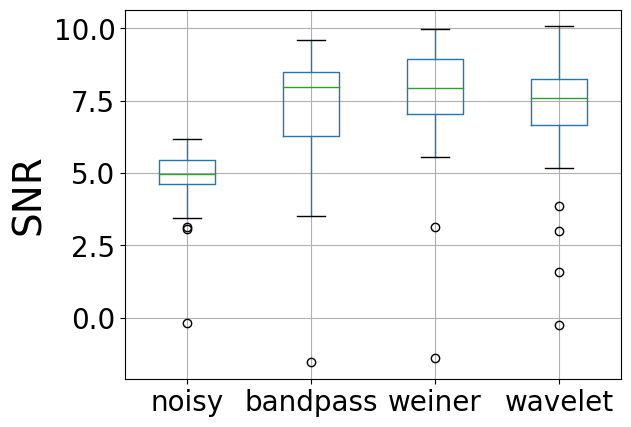

In [44]:
plt.figure(figsize=(6.4,4.8))
results.loc[results['category']==5].boxplot(column=['noisy', 'bandpass', 'weiner', 'wavelet'], fontsize=20)
plt.ylabel('SNR', fontsize=28)

plt.savefig('snr5_denoising.pdf', format="pdf", bbox_inches="tight") 
plt.show()

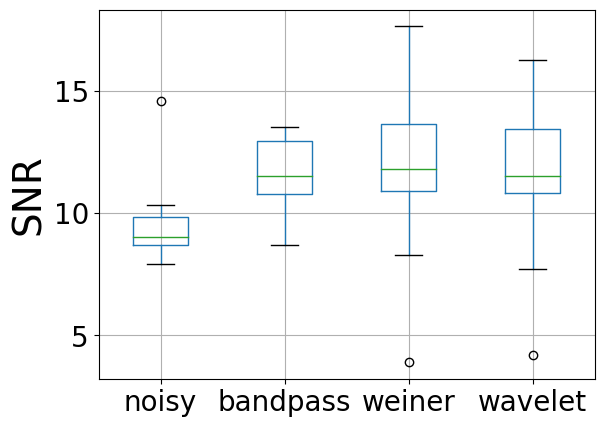

In [45]:
plt.figure(figsize=(6.4,4.8))
results.loc[results['category']==10].boxplot(column=['noisy', 'bandpass', 'weiner', 'wavelet'], fontsize=20)
plt.ylabel('SNR', fontsize=28)
plt.savefig('snr10_denoising.pdf', format="pdf", bbox_inches="tight") 

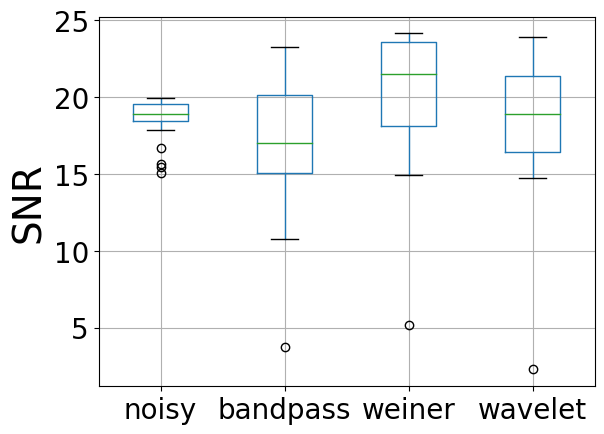

In [46]:
plt.figure(figsize=(6.4,4.8))
results.loc[results['category']==20].boxplot(column=['noisy', 'bandpass', 'weiner', 'wavelet'], fontsize=20)
plt.ylabel('SNR', fontsize=28)
plt.savefig('snr20_denoising.pdf', format="pdf", bbox_inches="tight") 

In [47]:
results = pd.DataFrame(columns=['file', 'noisy', 'bandpass', 'weiner', 'wavelet'])
for file in os.listdir(noisy_dir):
    if file.endswith('.wav'):
        clean_signal, sr = librosa.load(clean_dir+file)
        noisy_signal, _ = librosa.load(noisy_dir+file, sr=sr)
        bandpass_signal, _ = librosa.load(bandpass_dir+file, sr=sr)
        weiner_signal, _ = librosa.load(weiner_dir+file, sr=sr)
        wavelet_signal, _ = librosa.load(wavelet_dir+file, sr=sr)
        
        max_len = max(len(noisy_signal), len(clean_signal), len(bandpass_signal), len(weiner_signal), len(wavelet_signal))
        clean_signal = np.pad(clean_signal, (0, max_len-len(clean_signal)), 'constant')
        noisy_signal = np.pad(noisy_signal, (0, max_len-len(noisy_signal)), 'constant')
        bandpass_signal = np.pad(bandpass_signal, (0, max_len-len(bandpass_signal)), 'constant')
        weiner_signal = np.pad(weiner_signal, (0, max_len-len(weiner_signal)), 'constant')
        wavelet_signal = np.pad(wavelet_signal, (0, max_len-len(wavelet_signal)), 'constant')
        
        new_row = [file, distortion(clean_signal, noisy_signal), distortion(clean_signal, bandpass_signal), distortion(clean_signal, weiner_signal), distortion(clean_signal, wavelet_signal)]
        results.loc[len(results)]=new_row

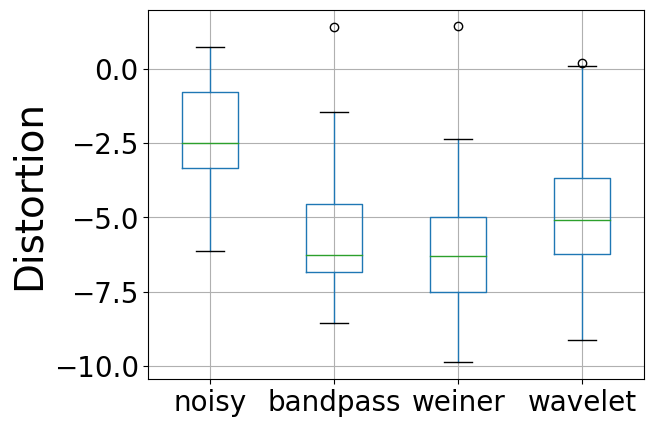

In [48]:
plt.figure(figsize=(6.4,4.8))
results.loc[snr5_index].boxplot(fontsize=20)
plt.ylabel('Distortion', fontsize=28)
plt.savefig('snr5_distortion.pdf', format="pdf", bbox_inches="tight") 

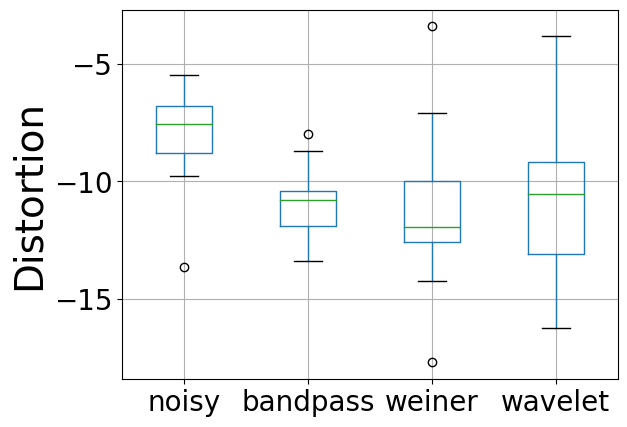

In [49]:
plt.figure(figsize=(6.4,4.8))
results.loc[snr10_index].boxplot(fontsize=20)
plt.ylabel('Distortion', fontsize=28)
plt.savefig('snr10_distortion.pdf', format="pdf", bbox_inches="tight") 

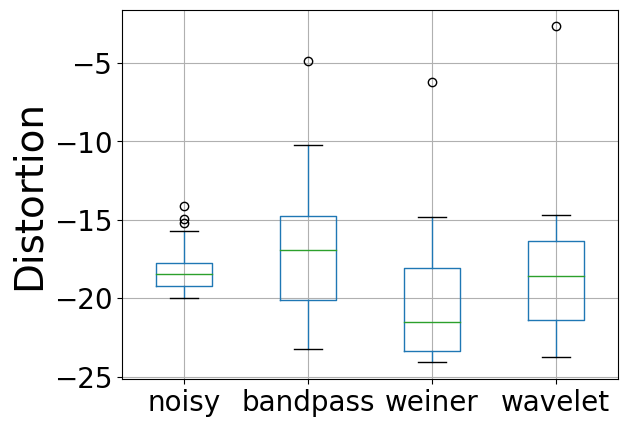

In [50]:
plt.figure(figsize=(6.4,4.8))
results.loc[snr20_index].boxplot(fontsize=20)
plt.ylabel('Distortion', fontsize=28)
plt.savefig('snr20_distortion.pdf', format="pdf", bbox_inches="tight") 